<a href="https://colab.research.google.com/github/ekaratnida/Applied-machine-learning/blob/master/Week10-desicion-tree/decision-trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<left><img width=25% src="https://github.com/ekaratnida/cornell-cs5785-2020-applied-ml/blob/main/notebooks/img/cornell_tech2.svg?raw=1"></left>

# Lecture 12: Tree-Based Algorithms

### Applied Machine Learning

__Volodymyr Kuleshov__<br>Cornell Tech

# Part 1: Decision Trees

We are now going to see a different way of defining machine models called *decision trees*.

# Review: Components of A Supervised Machine Learning Problem

At a high level, a supervised machine learning problem has the following structure:

$$ \underbrace{\text{Training Dataset}}_\text{Attributes + Features} + \underbrace{\text{Learning Algorithm}}_\text{Model Class + Objective + Optimizer } \to \text{Predictive Model} $$

# The UCI Diabetes Dataset

To explain what is a decision tree, we are going to use the UCI diabetes dataset that we have been working with earlier.

Let's start by loading this dataset.

In [20]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 4]
from sklearn import datasets

# Load the diabetes dataset
diabetes = datasets.load_diabetes(as_frame=True)
print(diabetes.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

We can also look at the data directly.

In [21]:
# Load the diabetes dataset
diabetes_X, diabetes_y = diabetes.data, diabetes.target

# create a binary risk feature
diabetes_y_risk = diabetes_y.copy()
diabetes_y_risk[:] = 0
diabetes_y_risk[diabetes_y > 150] = 1

# Print part of the dataset
diabetes_X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


# Decision Trees: Intuition

Decision tress are machine learning models that mimic how a human would approach this problem.
1. We start by picking a feature (e.g., age)
2. Then we *branch* on the feature based on its value (e.g, age > 65?)
3. We select and branch on one or more features (e.g., is it a man?)
4. Then we return an output that depends on all the features we've seen (e.g., a man over 65)

# Decision Trees: Example

Let's first see an example on the diabetes dataset.

We will train a decision tree using it's implementation in `sklearn`.

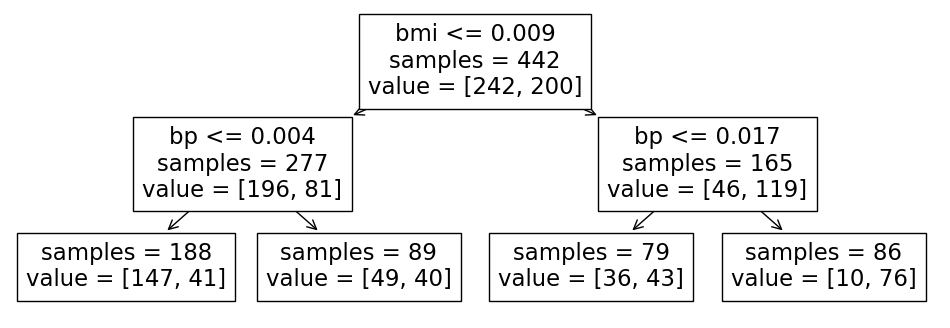

In [22]:
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree

# create and fit the model
clf = DecisionTreeClassifier(max_depth=2)
clf.fit(diabetes_X.iloc[:,:4], diabetes_y_risk)

# visualize the model
plot_tree(clf, feature_names=diabetes_X.columns[:4], impurity=False)
print('')

# Decision Rules

Let's now define a decision tree a bit more formally. The first important concept is that of a rule.
* A decision rule $r : \mathcal{X} \to \{\text{true}, \text{false}\}$ is a partition of the feature space into two disjoint regions, e.g.:
$$ r(x) = \begin{cases}\text{true} & \text{if } x_\text{bmi} \leq 0.009 \\ \text{false} & \text{if } x_\text{bmi} > 0.009 \end{cases} $$
* Normally, a rule applies to only one feature or attribute $x_j$ of $x$.
* If $x_j$ is continuous, the rule normally separates inputs $x_j$ into disjoint intervals $-\infty, c], (c, \infty)$.

# Decision Regions

The next important concept is that of a decision region.
* A decision region $R\subseteq \mathcal{X}$ is a subset of the feature space defined by the application of a set of rules $r_1, r_2, \ldots, r_m$ and their values $v_1, v_2, \ldots, v_m \in \{\text{true}, \text{false}\}$, i.e.:
$$ R = \{x \in \mathcal{X} \mid r_1(x) = v_1 \text{ and } \ldots \text{ and } r_m(x) = v_m \} $$
* For example, a decision region in the diabetes problem is:
$$ R = \{x \in \mathcal{X} \mid x_\text{bmi} \leq 0.009 \text{ and } x_\text{bp} > 0.004 \} $$

# Decision Trees: Definition

A decision tree is a model $f : \mathcal{X} \to \mathcal{Y}$ of the form
$$ f(x) = \sum_{R \in \mathcal{R}} y_R \mathbb{I}\{x \in R\}. $$
* The $\mathbb{I}\{\cdot\}$ is an indicator function (one if $\{\cdot\}$ is true, else zero) and values $y_R \in \mathcal{Y}$ are the outputs for that region.
* The set $\mathcal{R}$ is a collection of decision regions. They are obtained by *recursive binary splitting*.
* The rules defining the regions $\mathcal{R}$ can be organized into a tree, with one rule per internal node and regions being the leaves.

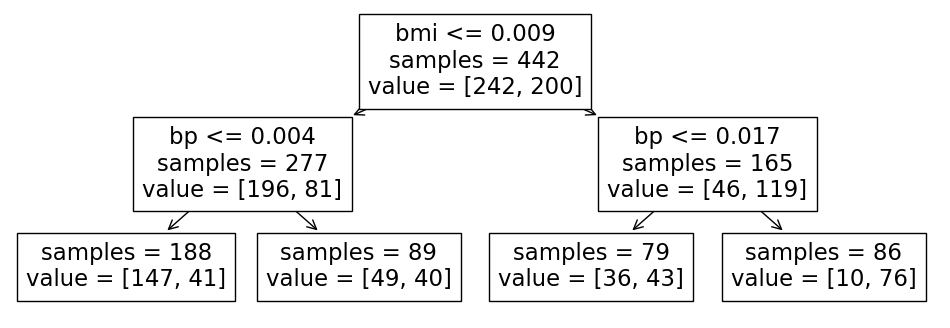

In [23]:
plot_tree(clf, feature_names=diabetes_X.columns[:4], impurity=False)
print('')

We can also illustrate decision trees via this figure from Hastie et al.

<left><img width=50% src="https://github.com/ekaratnida/cornell-cs5785-2020-applied-ml/blob/main/notebooks/img/decision_tree.png?raw=1"></left>

The illustrations are as follows:
* Top left: regions that cannot be represented by a tree
* Top right: regions that can be represented by a tree
* Bottom left: tree generating the top right regions
* Bottom right: function values assigned to the regions

# Pros and Cons of Decision Trees

Decision trees are important models in machine learning
* They are highly interpretable.
* Require little data preparation (no rescaling, handle continuous and discrete features).

Their main disadvantages are that:
* If they stay small and interpretable, they are not as powerful.
* If they are large, they easily overfit and are hard to regularize.

<left><img width=25% src="https://github.com/ekaratnida/cornell-cs5785-2020-applied-ml/blob/main/notebooks/img/cornell_tech2.svg?raw=1"></left>
# Part 2: Learning Decision Trees

We saw how decision trees are represented. How do we now learn them from data?


# The Components of A Supervised Machine Learning Algorithm

We can also define the high-level structure of a supervised learning algorithm as consisting of three components:
* A __model class__: the set of possible models we consider.
* An __objective__ function, which defines how good a model is.
* An __optimizer__, which finds the best predictive model in the model class according to the objective function

# Recall: Decision Trees

A decision tree is a model $f : \mathcal{X} \to \mathcal{Y}$ of the form
$$ f(x) = \sum_{R \in \mathcal{R}} y_R \mathbb{I}\{x \in R\}. $$
* The $\mathbb{I}\{\cdot\}$ is an indicator function (one if $\{\cdot\}$ is true, else zero) and values $y_R \in \mathcal{Y}$ are the outputs for that region.
* The set $\mathcal{R}$ is a collection of decision regions. They are obtained by *recursive binary splitting*.
* The rules defining the regions $\mathcal{R}$ can be organized into a tree, with one rule per internal node and regions being the leaves.

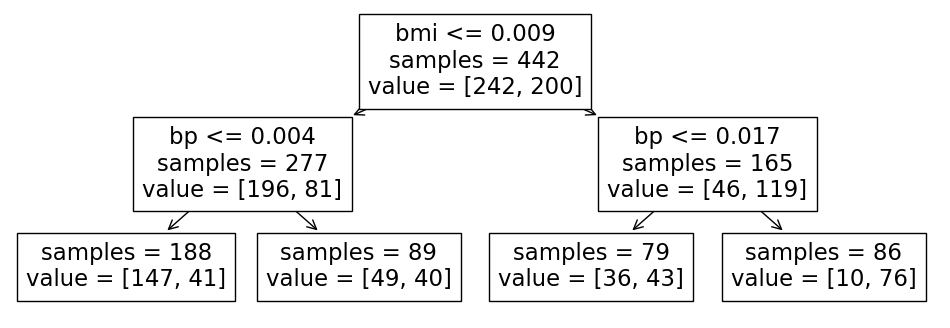

In [24]:
plot_tree(clf, feature_names=diabetes_X.columns[:4], impurity=False)
print('')

We can also illustrate decision trees via this figure from Hastie et al.

<left><img width=50% src="https://github.com/ekaratnida/cornell-cs5785-2020-applied-ml/blob/main/notebooks/img/decision_tree.png?raw=1"></left>

# Learning Decision Trees

At a high level, decision trees are grown by adding nodes one at a time.

```python
def build_tree(tree, data):
    whlie tree.is_complete() is False:
        region, region_data = tree.get_region()
        new_rule = split_region(region_data)
        tree.add_rule(region, new_rule)
```

Most often, we build the tree until it reaches a maximum number of nodes. The crux of the algorithm is in `split_region`.

There is also a recursive formulation of this algorithm:

```python
def build_tree(data, depth):
    if depth < MAX_DEPTH:
        # internal node
        rule, data_left, data_right = get_new_rule(tree, data)
        left_subtree = build_tree(data_left, depth+1)
        right_subtree = build_tree(data_right, depth+1)
        return create_node(new_rule, left_subtree, right_subtree)
    else:
        # leaf node
        return create_terminal_node(data)
```

# Learning New Decision Rules

How does the `split_region` function choose new rule $r$? Given a dataset $\mathcal{D} = \{(x^{(i)}, y^{(i)}\mid i =1,2,\ldots,n\}$, we greedily choose the rule that achieves the dataset split with the lowest possible loss.

This can be written as the following optimization problem:
$$ \min_{r \in \mathcal{U}} \left( \underbrace{L(\{(x, y) \in \mathcal{D} \mid r(x) = \text{T}\})}_\text{left subtree} +  \underbrace{L(\{(x, y) \in \mathcal{D} \mid r(x) = \text{F}\}}_\text{right subtree})\right) $$

where $L$ is a loss function over a subset of the data flagged by the rule and $\mathcal{U}$ is the set of possible rules.

What is the set of possible rules? When $x$ has continuous features, the rules have the following form:
$$ r(x) = \begin{cases}\text{true} & \text{if } x_j \leq t \\ \text{false} & \text{if } x_j > t \end{cases} $$
for a feature index $j$ and threshold $t \in \mathbb{R}$.

When $x$ has categorial features, rules may have the following form:
$$ r(x) = \begin{cases}\text{true} & \text{if } x_j = t_k \\ \text{false} & \text{if } x_j \neq t_k \end{cases} $$
for a feature index $j$ and possible value $t_k$ for $x_j$.

# Objectives for Trees: Regression

What loss functions might we want to use? In regression, it is common to minimize the L2 error between the data and the single best prediction we can make on this data:
$$ L(\mathcal{D}) = \sum_{(x, y) \in \mathcal{D}} \left( y - \texttt{average-y}(\mathcal{D}) \right)^2. $$

If this was a leaf node, we would predict $\texttt{average-y}(\mathcal{D})$, the average $y$ in the data. The above loss measures the resulting squared error.

This results in the following optimization problem for selecting a decision rule:
$$ \min_{r \in \mathcal{U}} \sum_{(x, y) \in \mathcal{D} \,\mid\, r(x) = \text{true}} \left( y - p_\text{true}(r) \right)^2 +  \sum_{(x, y) \in \mathcal{D} \,\mid\, r(x) = \text{false}} \left( y - p_\text{false}(r) \right)^2 $$

where $p_\text{true}(r) = \texttt{average-y}(\{(x, y) \mid (x, y) \in \mathcal{D} \text{ and } r(x) = \text{true}\})$ and $p_\text{false}(r) = \texttt{average-y}(\{(x, y) \mid (x, y) \in \mathcal{D} \text{ and } r(x) = \text{false}\})$ are the average predictions on each part of the data split.

# Objectives for Trees: Classification

In classification, we may similarly use the misclassification rate
$$ L(\mathcal{D}) = \sum_{(x, y) \in \mathcal{D}} \mathbb{I} \left\{ y = \texttt{most-common-y}(\mathcal{D}) \right\}. $$

If this was a leaf node, we would predict $\texttt{most-common-y}(\mathcal{D})$, the most common class $y$ in the data. The above loss measures the resulting misclassification error.

Other losses that can be used include the entropy or the gini index. These all optimize for a split in which different classes do not mix.

# Other Practical Considerations

A few additional comments on the above training procedure;
* Nodes are added to until tree reaches a maximum depth or the leaves can't be split anymore.
* In practice trees are also often pruned in order to reduce overfitting.
* There exist alternative algorithms, including ID3, C4.5, C5.0. See Hastie et al. for details.

# Algorithm: Classification and Regression Trees (CART)

* __Type__: Supervised learning (regression and classification).
* __Model family__: Decision trees.
* __Objective function__: Squared error, mislcassification error, Gini index, etc.
* __Optimizer__: Greedy addition of rules, followed by pruning.

<left><img width=25% src="https://github.com/ekaratnida/cornell-cs5785-2020-applied-ml/blob/main/notebooks/img/cornell_tech2.svg?raw=1"></left>
# Part 3: Bagging

Next, we are going to see a general technique to improve the performance of machine learning algorithms.

We will then apply it to decision trees to define an improved algorithm.

# Review: Overfitting

Overfitting is one of the most common failure modes of machine learning.
* A very expressive model (a high degree polynomial) fits the training dataset perfectly.
* The model also makes wildly incorrect prediction outside this dataset, and doesn't generalize.

Recall this example, in which we take random samples around a true function.

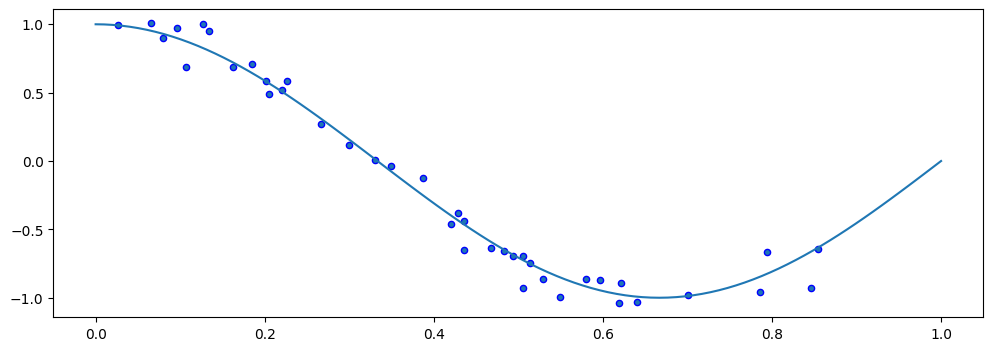

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def true_fn(X):
    return np.cos(1.5 * np.pi * X)

np.random.seed(2)
n_samples = 40
X = np.sort(np.random.rand(n_samples))
y = true_fn(X) + np.random.randn(n_samples) * 0.1

X_test = np.linspace(0, 1, 100)
plt.plot(X_test, true_fn(X_test), label="True function")
plt.scatter(X, y, edgecolor='b', s=20, label="Samples")

# Fitting High-Degree Polynomials

Let's see what happens if we fit a high degree polynomial to random samples of 20 points from this dataset.

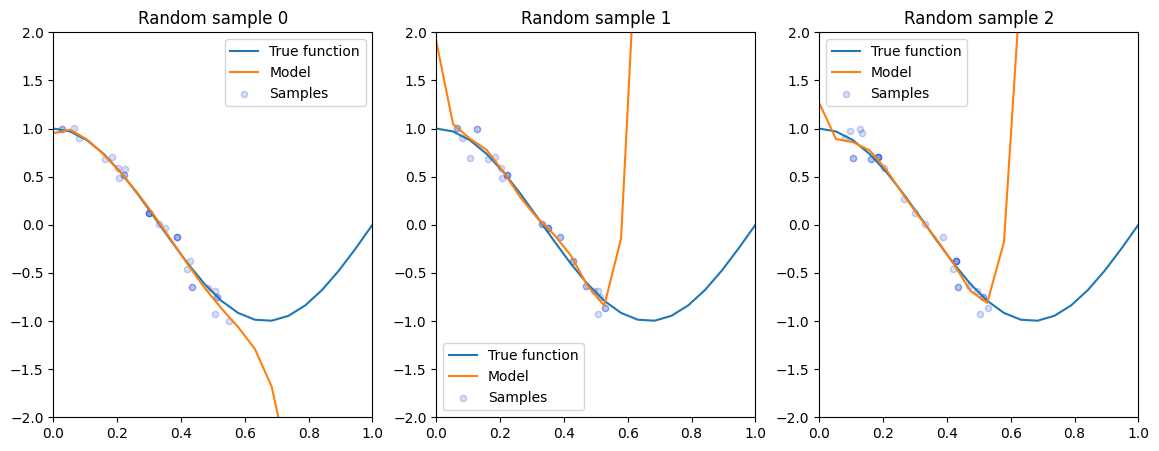

In [26]:
n_plots, X_line = 3, np.linspace(0,1,20)
plt.figure(figsize=(14, 5))
for i in range(n_plots):
    ax = plt.subplot(1, n_plots, i + 1)
    random_idx = np.random.randint(0, 30, size=(30,))
    X_random, y_random = X[random_idx], y[random_idx]

    polynomial_features = PolynomialFeatures(degree=6, include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("pf", polynomial_features), ("lr", linear_regression)])
    pipeline.fit(X_random[:, np.newaxis], y_random)

    ax.plot(X_line, true_fn(X_line), label="True function")
    ax.plot(X_line, pipeline.predict(X_line[:, np.newaxis]), label="Model")
    ax.scatter(X_random, y_random, edgecolor='b', s=20, label="Samples", alpha=0.2)
    ax.set_xlim((0, 1))
    ax.set_ylim((-2, 2))
    ax.legend(loc="best")
    ax.set_title('Random sample %d' % i)

# High-Variance Models

Each small subset of the data that we train on results is a very different model.

An algorithm that has a tendency to overfit is also called *high-variance*, because it outputs a predictive model that varies a lot if we slightly perturb the dataset.

# Bagging: Bootstrap Aggregation

The idea of *bagging* is to reduce model variance by averaging many models trained on random subsets of the data.

```python
for i in range(n_models):
    # collect data samples and fit models
    X_i, y_i = sample_with_replacement(X, y, n_samples)
    model = Model().fit(X_i, y_i)
    ensemble.append(model)

# output average prediction at test time:
y_test = ensemble.average_prediction(x_test)
```
The data samples are taken with replacement and known as bootstrap samples.

# Bagged Polynomial Regression

Let's apply bagging to our polynomial regression problem.

We are going to train a large number of polynomial regressions on random subsets of the dataset of points that we created earlier.

We start by training an ensemble of bagged models.

In [27]:
n_models, n_subset = 10000, 30
ensemble, Xs, ys = [], [], []
for i in range(n_models):
    # take a random subset of the data
    random_idx = np.random.randint(0, 30, size=(n_subset,))
    X_random, y_random = X[random_idx], y[random_idx]

    # train a polynomial regression model
    polynomial_features = PolynomialFeatures(degree=6, include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("pf", polynomial_features), ("lr", linear_regression)])
    pipeline.fit(X_random[:, np.newaxis], y_random)

    # add it to our set of bagged models
    ensemble += [pipeline]
    Xs += [X_random]
    ys += [y_random]

Let's visualize the prediction of the bagged model on each random dataset sample and compare to predictions from an un-bagged models.

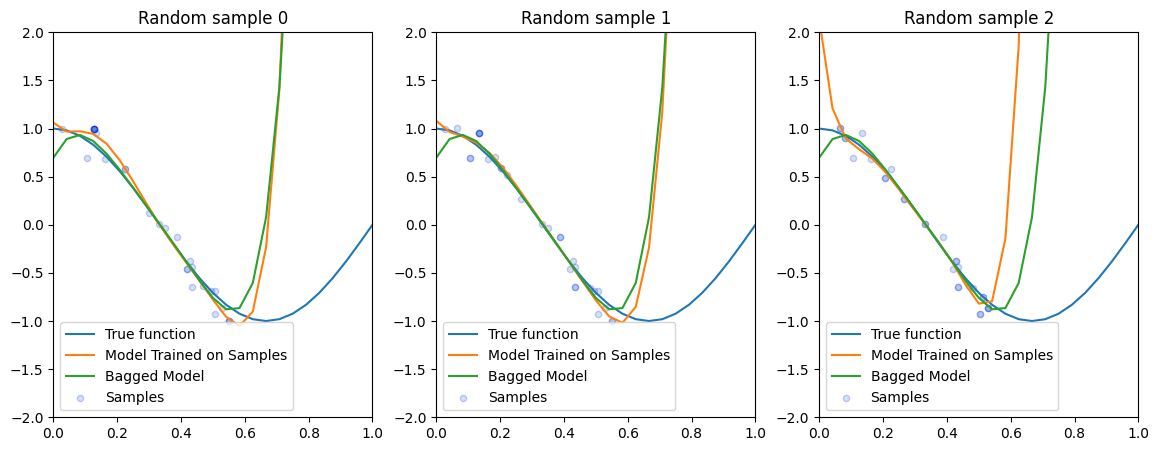

In [28]:
n_plots, X_line = 3, np.linspace(0,1,25)
plt.figure(figsize=(14, 5))
for i in range(n_plots):
    ax = plt.subplot(1, n_plots, i + 1)

    # generate average predictions
    y_lines = np.zeros((25, n_models))
    for j, model in enumerate(ensemble):
        y_lines[:, j] = model.predict(X_line[:, np.newaxis])
    y_line = y_lines.mean(axis=1)

    # visualize them
    ax.plot(X_line, true_fn(X_line), label="True function")
    ax.plot(X_line, y_lines[:,i], label="Model Trained on Samples")
    ax.plot(X_line, y_line, label="Bagged Model")
    ax.scatter(Xs[i], ys[i], edgecolor='b', s=20, label="Samples", alpha=0.2)
    ax.set_xlim((0, 1))
    ax.set_ylim((-2, 2))
    ax.legend(loc="best")
    ax.set_title('Random sample %d' % i)

# Extensions of Bagging

There exist a few closely related techniques to bagging.
* Pasting is when samples are taken without replacement.
* Random features are when we randomly sample the features.
* Random patching is when we do both of the above.

# Summary: Bagging

Bagging is a general technique that can be used with high-variance ML algorithms.

It averages predictions from multiple models trained on random subset of the data.

<left><img width=25% src="https://github.com/ekaratnida/cornell-cs5785-2020-applied-ml/blob/main/notebooks/img/cornell_tech2.svg?raw=1"></left>
# Part 4: Random Forests

Next, let's see how bagging can be applied to decision trees. This will also provide us with a new algorithm.


# Review: Bagging

The idea of *bagging* is to reduce model variance by averaging many models trained on random subsets of the data.

```python
for i in range(n_models):
    # collect data samples and fit models
    X_i, y_i = sample_with_replacement(X, y, n_samples)
    model = Model().fit(X_i, y_i)
    ensemble.append(model)

# output average prediction at test time:
y_test = ensemble.average_prediction(y_test)
```
The data samples are taken with replacement and known as bootstrap samples.

# Review: Decision Trees

A decision tree is a model $f : \mathcal{X} \to \mathcal{Y}$ of the form
$$ f(x) = \sum_{R \in \mathcal{R}} y_R \mathbb{I}\{x \in R\}. $$
* The $\mathbb{I}\{\cdot\}$ is an indicator function (one if $\{\cdot\}$ is true, else zero) and values $y_R \in \mathcal{Y}$ are the outputs for that region.
* The set $\mathcal{R}$ is a collection of decision regions. They are obtained by *recursive binary splitting*.
* The rules defining the regions $\mathcal{R}$ can be organized into a tree, with one rule per internal node and regions being the leaves.

We can also illustrate decision trees via this figure from Hastie et al.

<left><img width=50% src="https://github.com/ekaratnida/cornell-cs5785-2020-applied-ml/blob/main/notebooks/img/decision_tree.png?raw=1"></left>

# Classification Dataset: Iris Flowers

Let's now look at the performance of decision trees on a new dataset, Iris flowers.

It's a classical dataset originally published by [R. A. Fisher](https://en.wikipedia.org/wiki/Ronald_Fisher) in 1936. Nowadays, it's widely used for demonstrating machine learning algorithms.

In [29]:
import numpy as np
import pandas as pd
from sklearn import datasets

# Load the Iris dataset
iris = datasets.load_iris(as_frame=True)

print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [30]:
# print part of the dataset
iris_X, iris_y = iris.data, iris.target
pd.concat([iris_X, iris_y], axis=1).head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


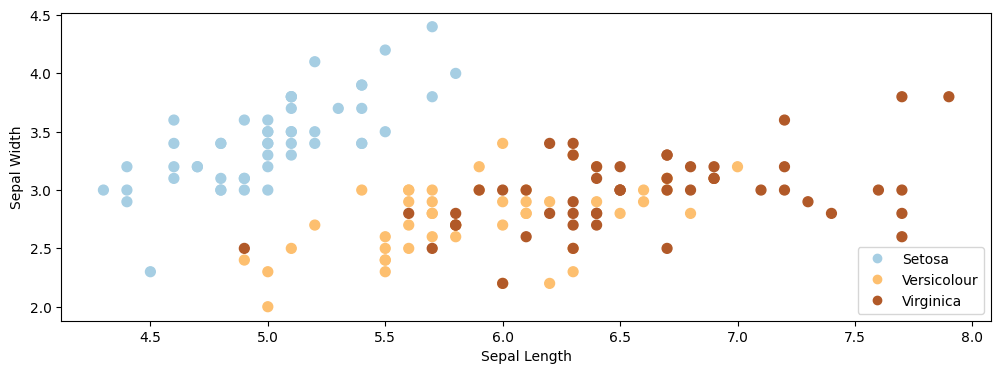

In [31]:
# Plot also the training points
p1 = plt.scatter(iris_X.iloc[:, 0], iris_X.iloc[:, 1], c=iris_y, s=50, cmap=plt.cm.Paired)
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.legend(handles=p1.legend_elements()[0], labels=['Setosa', 'Versicolour', 'Virginica', 'Query'], loc='lower right')

# Decision Trees on the Flower Dataset

Let's now consider what happens when we train a decision tree on the Iris flower dataset.

The code below will be used to visualize predictions from decision trees on this dataset.

In [32]:
# https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import ListedColormap
import warnings
warnings.filterwarnings("ignore")

def make_grid(X):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X.iloc[:, 0].min() - 0.1, X.iloc[:, 0].max() + 0.1
    y_min, y_max = X.iloc[:, 1].min() - 0.1, X.iloc[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    return xx, yy, x_min, x_max, y_min, y_max

def make_2d_preds(clf, X):
    xx, yy, x_min, x_max, y_min, y_max = make_grid(X)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    return Z

def make_2d_plot(ax, Z, X, y):
    # Create color maps
    cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
    cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])

    xx, yy, x_min, x_max, y_min, y_max = make_grid(X)

    # Put the result into a color plot
    ax.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

    # Plot also the training points
    ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=plt.cm.Paired, edgecolor='k', s=50)
    ax.set_xlabel('Sepal Length')
    ax.set_ylabel('Sepal Width')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())

We may now train and visualize a decision tree on this dataset.

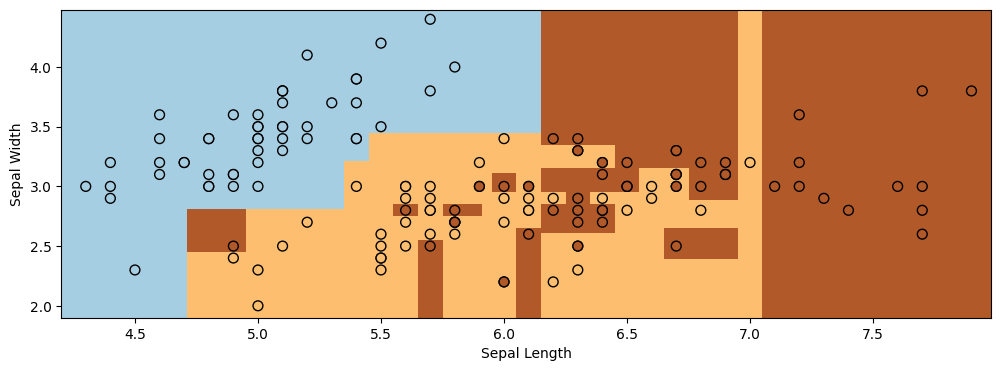

In [33]:
# Train a Decision Tree Model
ax = plt.gca()
X = iris_X.iloc[:,:2]
clf = DecisionTreeClassifier()
clf.fit(X, iris_y)
Z = make_2d_preds(clf, X)
make_2d_plot(ax, Z, X, iris_y)

# Two Problems With Decision Trees

We see two problems with the output of the decision tree on the Iris dataset:
* The decision boundary between the two classes is very non-smooth and blocky.
* The decision tree overfits the data and the decision regions are highly fragmented.

# High-Variance Decision Trees

When the trees have sufficiently high depth, they can quickly overfit the data.

Recall that this is called the *high variance* problem, because small perturbations of the data lead to large changes in model predictions.

Consider the perofmrance of a decision tree classifier on 3 random subsets of the data.

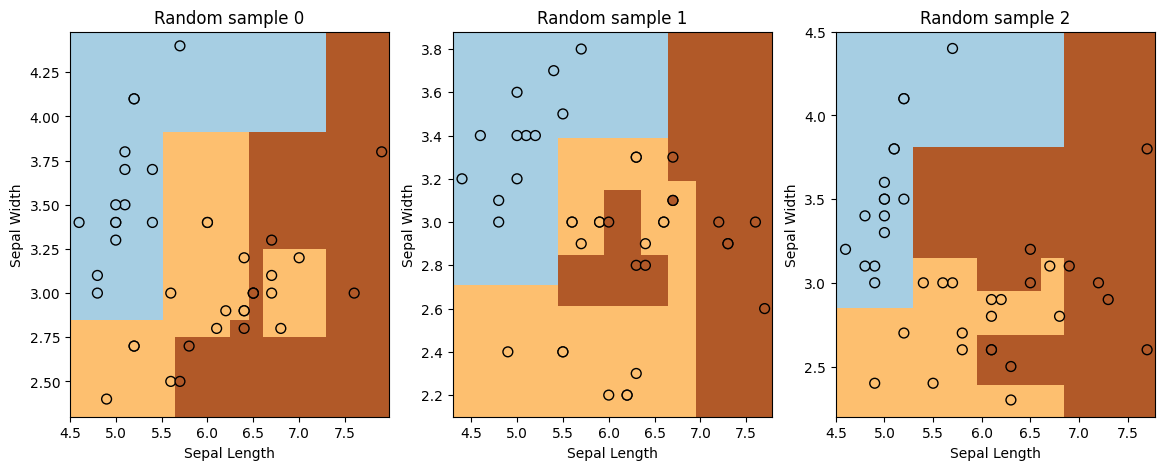

In [34]:
n_plots, n_flowers, n_samples = 3, iris_X.shape[0], 40
plt.figure(figsize=(14, 5))
for i in range(n_plots):
    ax = plt.subplot(1, n_plots, i + 1)
    random_idx = np.random.randint(0, n_flowers, size=(n_samples,))
    X_random, y_random = iris_X.iloc[random_idx, :2], iris_y[random_idx]

    clf = DecisionTreeClassifier()
    clf.fit(X_random, y_random)
    Z = make_2d_preds(clf, X_random)
    make_2d_plot(ax, Z, X_random, y_random)
    ax.set_title('Random sample %d' % i)

# Random Forests

In order to reduce the variance of the basic decision tree, we apply bagging -- the variance reduction technique that we have seen earlier.

We refer to bagged decision trees as *Random Forests*.

Instantiating our definition of bagging with decision trees, we obtain the following pseudocode defintion of random forests:

```python
for i in range(n_models):
    # collect data samples and fit models
    X_i, y_i = sample_with_replacement(X, y, n_samples)
    model = DecisionTree().fit(X_i, y_i)
    random_forest.append(model)

# output average prediction at test time:
y_test = random_forest.average_prediction(y_test)
```

We may implement random forests in python as follows:

In [35]:
np.random.seed(1000)
n_models, n_flowers, n_subset = 300, iris_X.shape[0], 10
random_forest = []
for i in range(n_models):
    # sample the data with replacement
    random_idx = np.random.randint(0, n_flowers, size=(n_subset,))
    X_random, y_random = iris_X.iloc[random_idx, :2], iris_y[random_idx]

    # train a decision tree model
    clf = DecisionTreeClassifier()
    clf.fit(X_random, y_random)

    # append it to our ensemble
    random_forest += [clf]

# Random Forests on the Flower Dataset

Consider now what happens when we deploy random forests on the same dataset as before.

Now, each prediction is the average on the set of bagged decision trees.

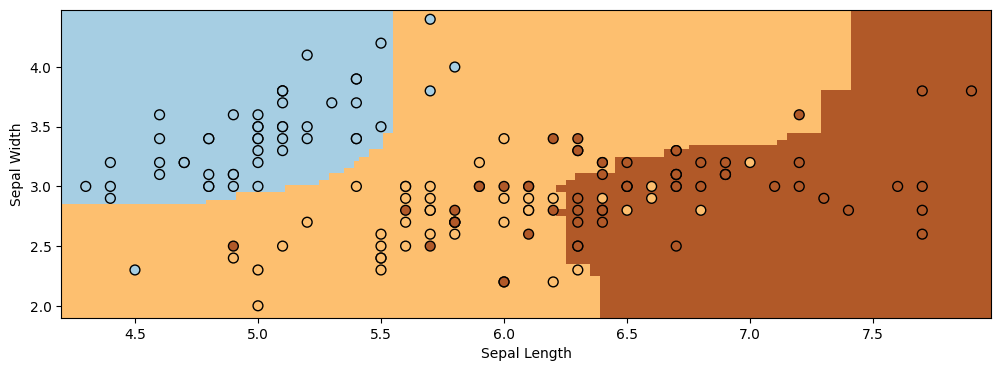

In [36]:
# Visualize predictions from a random forest
ax = plt.gca()

# compute average predictions from all the models in the ensemble
X_all, y_all = iris_X.iloc[:,:2], iris_y
Z_list = []
for clf in random_forest:
    Z_clf = make_2d_preds(clf, X_all)
    Z_list += [Z_clf]
Z_avg = np.stack(Z_list, axis=2).mean(axis=2)

# visualize predictions
make_2d_plot(ax, np.rint(Z_avg), X_all, y_all)

The boundaries are much more smooth and well-behaved.

# Algorithm: Random Forests

* __Type__: Supervised learning (regression and classification).
* __Model family__: Bagged decision trees.
* __Objective function__: Squared error, mislcassification error, Gini index, etc.
* __Optimizer__: Greedy addition of rules, followed by pruning.

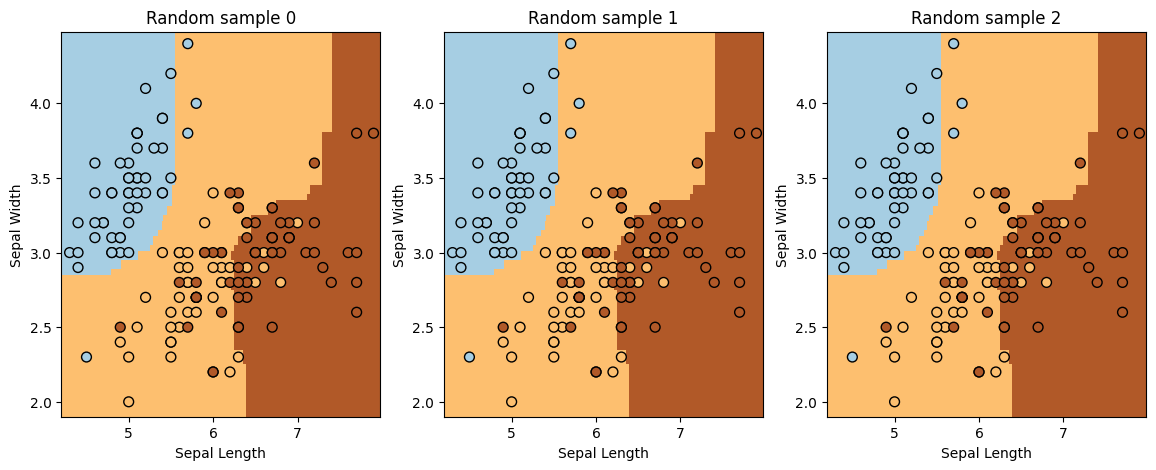

In [37]:
n_plots, n_flowers, n_samples = 3, iris_X.shape[0], 40
plt.figure(figsize=(14, 5))
X_all, y_all = iris_X.iloc[:,:2], iris_y
for i in range(n_plots):
    ax = plt.subplot(1, n_plots, i + 1)
    random_idx = np.random.randint(0, n_flowers, size=(n_samples,))
    X_random, y_random = X_all.iloc[random_idx, :2], y_all[random_idx]

    Z_list = []
    for clf in random_forest:
        Z_clf = make_2d_preds(clf, X_all)
        Z_list += [Z_clf]
    Z_avg = np.rint(np.stack(Z_list, axis=2).mean(axis=2))

    make_2d_plot(ax, Z_avg, X_all, y_all)
    ax.set_title('Random sample %d' % i)

# Pros and Cons of Random Forests

Random forests remain a popular machine learning algorithm:
* They require little data preparation (no rescaling, handle continuous and discrete features, work well for classification and regression).
* They are often quite accurate.

Their main disadvantages are that:
* They are not interpretable.
* They do not work with unstructured data (images, audio).